In [91]:
import cv2
import math
from matplotlib import pyplot as plt
import numpy as np
import face_recognition
import tensorflow as tf
from facenet.src import facenet
%matplotlib inline

In [2]:
face_cascade = cv2.CascadeClassifier('data/lbpcascade_frontalface_improved.xml')

In [3]:
capture = cv2.VideoCapture("data/Oblivion.mp4")

In [4]:
capture.isOpened()

True

In [5]:
(major_ver, minor_ver, subminor_ver) = (cv2.__version__).split('.')
if int(major_ver)  < 3 :
    fps = capture.get(cv2.cv.CV_CAP_PROP_FPS)
    print("Frames per second using video.get(cv2.cv.CV_CAP_PROP_FPS): {0}".format(fps))
else :
    fps = capture.get(cv2.CAP_PROP_FPS)
    print("Frames per second using video.get(cv2.CAP_PROP_FPS) : {0}".format(fps))

Frames per second using video.get(cv2.CAP_PROP_FPS) : 23.976023976023978


In [6]:
def detect_faces(frame):
    face_locations = []
    faces = []
    faces = face_recognition.face_locations(frame)
    if faces:
        for face in faces:
            face_locations.append(face)
    return face_locations

def detect_faces_cascade(frame):
    face_locations = []
    faces = []
    gray_img = cv2.cvtColor(frame.copy(), cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray_img, scaleFactor=1.1, minNeighbors=3)
    if len(faces) > 0:
        for face in faces:
            face_locations.append([face[1], face[0]+face[2], face[1]+face[3], face[0]])
    return face_locations

In [7]:
%%time
face_locations = None
sec = 0
faces = []
while len(faces) < 20:
    for i in range(int(math.ceil(fps)/2)):
        ret, frame = capture.read()
    sec += 1
    face_locations = [] or detect_faces(frame)
    fcs = [] #or detect_faces_cascade(frame)
    for face in fcs:
        face_locations.append(face)
    if face_locations:
        faces.append({'frame':frame, 'faces':face_locations})
        print("seconds",sec, "found", len(face_locations))
print(sec/2)

seconds 81 found 1
seconds 82 found 1
seconds 89 found 1
seconds 90 found 1
seconds 91 found 1
seconds 92 found 1
seconds 99 found 1
seconds 102 found 2
seconds 103 found 2
seconds 104 found 3
seconds 105 found 5
seconds 106 found 6
seconds 107 found 5
seconds 108 found 5
seconds 109 found 3
seconds 110 found 3
seconds 111 found 3
seconds 112 found 3
seconds 113 found 2
seconds 115 found 1
57.5
CPU times: user 2min 38s, sys: 1.87 s, total: 2min 40s
Wall time: 2min 26s


In [8]:
for face in faces:
    print(face['faces'])

[(268, 984, 397, 855)]
[(282, 984, 411, 855)]
[(167, 1108, 390, 885)]
[(167, 1133, 390, 910)]
[(192, 1207, 415, 984)]
[(192, 1256, 415, 1034)]
[(217, 984, 440, 761)]
[(356, 906, 511, 752), (202, 752, 356, 597)]
[(139, 1439, 325, 1253), (98, 1612, 253, 1457)]
[(139, 1315, 325, 1129), (81, 1543, 236, 1388), (339, 889, 494, 734)]
[(139, 1232, 325, 1047), (67, 1457, 196, 1328), (345, 944, 531, 758), (176, 1678, 265, 1589), (236, 545, 391, 390)]
[(150, 1182, 305, 1027), (366, 902, 552, 716), (96, 1343, 225, 1214), (168, 1601, 297, 1472), (201, 634, 387, 448), (196, 1668, 285, 1579)]
[(139, 1232, 325, 1047), (345, 902, 531, 716), (98, 1371, 253, 1216), (182, 1601, 311, 1472), (219, 545, 374, 390)]
[(325, 923, 511, 737), (167, 1285, 322, 1130), (222, 469, 407, 283), (163, 1537, 271, 1429), (186, 1698, 275, 1609)]
[(304, 861, 490, 675), (167, 1336, 322, 1182), (176, 1658, 265, 1569)]
[(325, 882, 511, 696), (160, 1377, 345, 1191), (110, 1515, 239, 1386)]
[(150, 1371, 305, 1216), (366, 861, 552,

In [9]:
for detection in faces:
    for face in detection['faces']:
        #cv2.rectangle(detection['frame'], (face[3], face[0]), (face[1], face[2]), (0, 255, 0),7)

SyntaxError: unexpected EOF while parsing (<ipython-input-9-43418fbe0d03>, line 3)

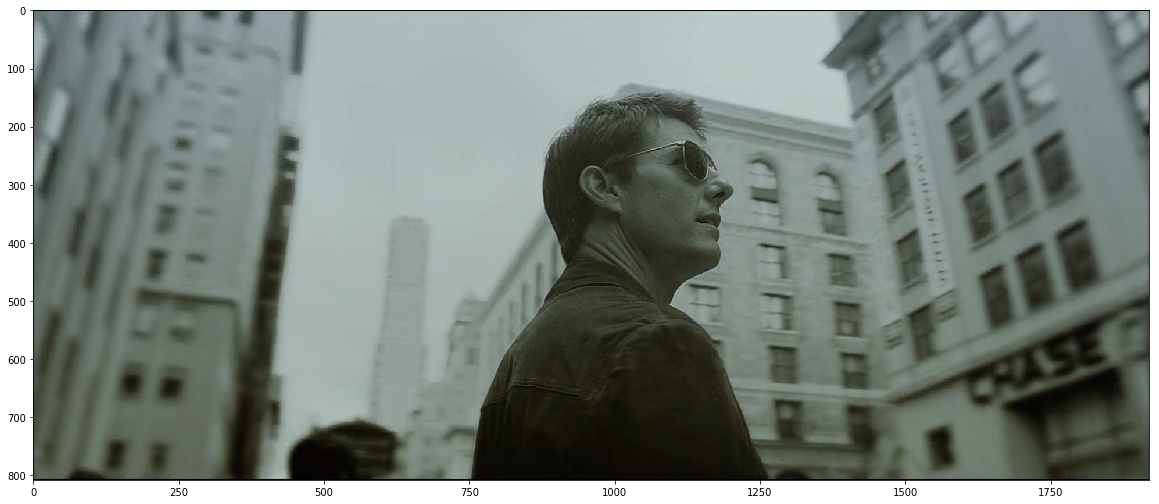

In [76]:
plt.figure(figsize=(20,10))
plt.imshow(faces[5]['frame'])
plt.show()

In [77]:
face_landmarks_list = face_recognition.face_landmarks(faces[5]['frame'])

In [95]:
desiredLeftEye = (0.35, 0.35)
desiredFaceWidth = 160

In [96]:
l_eye = np.array(face_landmarks_list[0]['left_eye']).reshape(6,2).mean(axis=0).astype(int)
r_eye = np.array(face_landmarks_list[0]['right_eye']).reshape(6,2).mean(axis=0).astype(int)

In [97]:
dY = r_eye[1] - l_eye[1]
dX = r_eye[0] - l_eye[0]
angle = np.degrees(np.arctan2(dY, dX))

In [98]:
desiredRightEyeX = 1.0 - desiredLeftEye[0]

In [99]:
dist = np.sqrt((dX ** 2) + (dY ** 2))
desiredDist = (desiredRightEyeX - desiredLeftEye[0])
desiredDist *= desiredFaceWidth
scale = desiredDist / dist

In [100]:
# compute center (x, y)-coordinates (i.e., the median point)
# between the two eyes in the input image
eyesCenter = ((l_eye[0] + r_eye[0]) // 2,
    (l_eye[1] + r_eye[1]) // 2)

# grab the rotation matrix for rotating and scaling the face
M = cv2.getRotationMatrix2D(eyesCenter, angle, scale)

# update the translation component of the matrix
tX = desiredFaceWidth * 0.5
tY = desiredFaceWidth * desiredLeftEye[1]
M[0, 2] += (tX - eyesCenter[0])
M[1, 2] += (tY - eyesCenter[1])

In [101]:
# apply the affine transformation
(w, h) = (desiredFaceWidth, desiredFaceWidth)
output = cv2.warpAffine(faces[5]['frame'], M, (w, h),
    flags=cv2.INTER_CUBIC)

In [102]:
plt.figure(figsize=(20,10))
plt.imshow(output)
plt.show()

In [104]:
with tf.Graph().as_default():
    with tf.Session() as sess:
        facenet.load_model("data/20170512-110547/")
        images_placeholder = tf.get_default_graph().get_tensor_by_name("input:0")
        embeddings = tf.get_default_graph().get_tensor_by_name("embeddings:0")
        phase_train_placeholder = tf.get_default_graph().get_tensor_by_name("phase_train:0")
        image_size = 256
        embedding_size = embeddings.get_shape()[1]
        
        # Run forward pass to calculate embeddings
        print('Runnning forward pass on LFW images')
        feed_dict = { images_placeholder:[output], phase_train_placeholder:False }
        emb_array = sess.run(embeddings, feed_dict=feed_dict)
        print(emb_array)
        #tpr, fpr, accuracy, val, val_std, far = lfw.evaluate(emb_array, 
        #    actual_issame, nrof_folds=args.lfw_nrof_folds)

        #print('Accuracy: %1.3f+-%1.3f' % (np.mean(accuracy), np.std(accuracy)))
        #print('Validation rate: %2.5f+-%2.5f @ FAR=%2.5f' % (val, val_std, far))

        #auc = metrics.auc(fpr, tpr)
        #print('Area Under Curve (AUC): %1.3f' % auc)
        #eer = brentq(lambda x: 1. - x - interpolate.interp1d(fpr, tpr)(x), 0., 1.)
        #print('Equal Error Rate (EER): %1.3f' % eer)

Model directory: data/20170512-110547/
Metagraph file: model-20170512-110547.meta
Checkpoint file: model-20170512-110547.ckpt-250000
'model_variables' collection should be of type 'byte_list', but instead is of type 'node_list'.
INFO:tensorflow:Restoring parameters from data/20170512-110547/model-20170512-110547.ckpt-250000
Runnning forward pass on LFW images
[[-0.00865735  0.0484806  -0.02054086  0.00562987  0.03605182  0.0713455
   0.09917535 -0.10472792 -0.0677746  -0.20970476  0.0325044  -0.1131225
  -0.0583889   0.00330362 -0.02504743 -0.03125291  0.03606595 -0.07349146
   0.00689111 -0.05325582  0.0429454  -0.18159078  0.05296024  0.10906164
   0.02892305  0.13552076  0.11156663 -0.008667   -0.11886119 -0.09481239
   0.01484949  0.16496907 -0.08713324  0.06975791 -0.02949527  0.05822007
   0.09109805 -0.1203058   0.08302212  0.14412472  0.06398077  0.00216238
   0.01675137 -0.03898083  0.00061408  0.10607372  0.064023    0.06058728
  -0.02675795 -0.12251391  0.02275905 -0.0023973